In [1]:
import flopy
import numpy as np
import matplotlib.pyplot as plt
import shutil
from pathlib import Path
import pandas as pd


from datetime import datetime
from tempfile import TemporaryDirectory
from tempfile import mkdtemp

import os
import platform
import subprocess
#from shapely.geometry import Polygon, Point
#from scipy.interpolate import make_interp_spline



In [2]:
def open_file(path):
    if platform.system() == "Windows":
        os.startfile(path)
    elif platform.system() == "Darwin":
        subprocess.Popen(["open", path])
    else:
        subprocess.Popen(["xdg-open", path])

# Plot Results

In [ ]:
# FDM 70 years
model_ws = 'C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1027155237_wasaga_8w84q7ca' 
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws = 'C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1027151129_wasaga_pzvlih61' ## Heterogeneity , Sigma=2
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
## Heterogeneity , Log Normal Sigma =0.4
model_ws = 'C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1027200024_wasaga_4bbtdli5'
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:

## Langmuir 
model_ws = Path('C:/Users/swan47/Documents/Data/_wasaga_regional_local/_T1027204957_wasaga_xiniyo6w_langmuir')
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:


model_ws = '/Volumes/WD Green/Data/pmwin_projects/_T1027204957_wasaga_xiniyo6w_langmuir'
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:

model_ws = Path('/var/folders/hy/v14_l_r91tl2w5s9xfm9p2kc0000gn/T/_T1027235020_wasaga_722y1j58')
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

## GW Budget  test

In [ ]:
#T
model_ws = Path('C:/Users/swan47/AppData/Local/Temp/_T1113225454_wasaga_4scesssj')
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws = Path('C:/Users/swan47/AppData/Local/Temp/_T1114011712_wasaga_hhe2cnnr')
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws = Path('C:/Users/swan47/AppData/Local/Temp/_T1114024022_wasaga__5_pv4rn')
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws = Path('C:/Users/swan47/AppData/Local/Temp/_T1114164044_wasaga_2cy8k67o') ##70 years
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws = Path('C:/Users/swan47/AppData/Local/Temp/_T1115164527_wasaga_8g0heui5') ##70 years, updated icbund
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws

In [ ]:
model_ws = Path('/var/folders/hy/v14_l_r91tl2w5s9xfm9p2kc0000gn/T/_T1125184206_wasaga_0s9zwl7u') ##70 years, updated icbund
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1126155437_wasaga_mcympo81') # new base model
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:

model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1126164037_wasaga_wi_39aij') # new fast conditions
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:

model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1126173234_wasaga_2r9_cyma') # new slower conditions
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1126174811_wasaga_gcs_jye6') # new fast conditions 500 years
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)


In [ ]:
model_ws = Path('/var/folders/hy/v14_l_r91tl2w5s9xfm9p2kc0000gn/T/_T1126231349_wasaga_i_3l1xt3') ## faster condition with lower dispersivity
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:

model_ws =  Path('/var/folders/hy/v14_l_r91tl2w5s9xfm9p2kc0000gn/T/_T1127092500_wasaga_6w77qvj_') # even faster conditions
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

## Comfort Station

In [ ]:

model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1207162357_wasaga_o5u9s4y2') # old base condition, comfort station
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:

model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1207175420_wasaga_5n5avyuh') # new base condition, comfort station,  no nearshore drain
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1207191219_wasaga_f80k7t8f') # new base condition, comfort station at 1250m,  no nearshore drain
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1208152949_wasaga_zok1vxe8') # new base condition, comfort station at 1250m,  no nearshore drain, 500 years
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1208174955_wasaga_rie7u9w2') # new base condition, comfort station at 1250m,  no nearshore drain, 500 years
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1213133434_wasaga_a4inkdh2') # new base condition, comfort station at 1250m,  with drain, 10 year , fine grid
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)



In [ ]:

model_ws =  Path('D:\\_T1213141439_wasaga_kd0ajh1w') # new base condition, comfort station 70m from beach,  with drain, 10 year , fine grid
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)



In [ ]:


model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1213204545_wasaga_4xcfmuwd') # new base condition, comfort station 70m from beach,  with drain, 70 year , fine grid ## [moved to D]
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)



## Topography

In [ ]:
model_ws =  Path('/var/folders/hy/v14_l_r91tl2w5s9xfm9p2kc0000gn/T/_T1221063806_wasaga_rb3xqkdp') #
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

## Drain Conductance

In [ ]:

model_ws =  Path('/var/folders/hy/v14_l_r91tl2w5s9xfm9p2kc0000gn/T/_T1221085136_wasaga_u_d_bjei')  # 10
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:

model_ws =  Path('/var/folders/hy/v14_l_r91tl2w5s9xfm9p2kc0000gn/T/_T1221122318_wasaga_tucxxlkj')  # 1
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

## Real Septic data

In [ ]:

model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T0108211703_wasaga_jozjucwp')  # 56 years (if no sanitary   ) moved to D:
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T0109005814_wasaga_8t3rbwo4')  # 56 years 
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws =  Path('D:\\_T0110015920_wasaga_')  # 500 years
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T0117004900_wasaga_u57hpey6')  # 100 years， mf failed to converge at around 45 years
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:


model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T0117154134_wasaga_8jd3t6yk')  # 10 years， no drn
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:

model_ws =  Path( 'C:\\Users\\swan47\\AppData\\Local\\Temp\\_T0117182556_wasaga_6ocycvka' )  # 100 years， no drn
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:

model_ws =  Path( 'C:\\Users\\swan47\\AppData\\Local\\Temp\\_T0124210550_l85kj60c_Selfish_Scarf' )  # 100 years， no septic over drain
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:



model_ws =  Path( 'C:\\Users\\swan47\\AppData\\Local\\Temp\\_T0127200110_r_nrhqsu_Messy_Building' )  # 100 years， starting 1970, failed to converge
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:




model_ws =  Path( 'C:\\Users\\swan47\\AppData\\Local\\Temp\\_T0129015400_gprjceni_Fantastic_Road' )  # 100 years， only half septics added,  hclose and rclose are 1e-3, wetdry=-0.25
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:


model_ws =  Path( '/var/folders/hy/v14_l_r91tl2w5s9xfm9p2kc0000gn/T/_T0129064842_8xy4pi14_Clean_Ship' )  # 100 years， mf-nwt
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:

model_ws =  Path( 'C:\\Users\\swan47\\AppData\\Local\\Temp\\_T0129124627_bpus475d_Curious_Pants' )  # 100 years， pcg, coarse
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:

model_ws =  Path( 'C:\\Users\\swan47\\AppData\\Local\\Temp\\_T0129135259_qiskjpi1_Incredible_Alley' )  # 100 years， nwt, coarse
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws =  Path( '/var/folders/hy/v14_l_r91tl2w5s9xfm9p2kc0000gn/T/_T0129163039_wurzn3p5_Fresh_House')  # 100 years， nwt, coarse
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:

model_ws =  Path( '/var/folders/hy/v14_l_r91tl2w5s9xfm9p2kc0000gn/T/_T0131124602_4mr_tdpx_Beautiful_Museum')  # 100 years， nwt, mt3dusgs, one wel
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)a

In [ ]:

model_ws =  Path('H:/mf/_T0208024128__Cowardly_Bird')  
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws =  Path('H:/mf/_T0212022329__Brave_Chair')  
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [3]:


model_ws =  Path('H:/mf/_T0212235115__Thin_Map')   # 1000 years model
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

# DIS

In [24]:
dis = model.dis
nrow = dis.nrow
ncol = dis.ncol
nlay = dis.nlay

delr = 2200/nrow
delc = 2200/ncol
layer_thickness = 30/nlay
nper = model.dis.nper

# Cross-section


## hds

In [ ]:
# Safe way plot
# import matplotlib.pyplot as plt
# import flopy
# from pathlib import Path

# shoreline_distance = 1600

# hds = flopy.utils.binaryfile.HeadFile(model_ws / 'example_model.hds')
# times = hds.get_times()  # list of times
# kstpkpers = hds.get_kstpkper()  # list of (timestep, stress_period) tuples
# ibd = model.bas6.ibound.array

# output_folder = model_ws / '_output'  # Make sure this directory exists
# output_folder.mkdir(parents=True, exist_ok=True)  # Create output directory if it doesn't exist

# for idx, kstpkper in enumerate(kstpkpers):
#     fig, ax = plt.subplots(figsize=(15, 5))
#     xsect = flopy.plot.PlotCrossSection(model=model, line={"Column": 146}, ax=ax)
#     time = times[idx]  # get the time for the current kstpkper
#     year = int(time / 365)  # calculate the year assuming time is in days
    
#     head_data = hds.get_data(kstpkper=kstpkper)
#     masked_head_data = np.ma.masked_where(ibd == 0, head_data)

#     cs = xsect.plot_array(masked_head_data, cmap="viridis")
#     plt.colorbar(cs, ax=ax)
    
#     contour_levels = np.arange(164, 188, 0.5)
#     contour_set = xsect.contour_array(masked_head_data, levels=contour_levels, colors="black", ax=ax)
#     plt.clabel(contour_set, inline=True, fontsize=10, fmt="%1.1f")

#     xsect.plot_ibound(color_noflow='grey')
#     plt.axvline(x=shoreline_distance, color='black', linestyle='--')
#     plt.text(1700, 185, 'Shoreline', ha='center', va='bottom', fontsize=12)

#     ax.set_title(f'Year: {year}')  # Update the title to show the year
    
#     plt.savefig(output_folder / f'hds_{kstpkper[1]}_{kstpkper[0]}_year{year}.png')  # Save figure with stress period, time step, and year in filename
#     plt.close(fig)  # Close the figure to free memory


In [ ]:

# Constants
shoreline_distance = 1600
column_idx = 146

# Load data
hds = flopy.utils.binaryfile.HeadFile(model_ws / 'example_model.hds')
times = hds.get_times()
kstpkpers = hds.get_kstpkper()
ibd = model.bas6.ibound.array

# Prepare output directory
output_folder = model_ws / '_output' / 'hds'
output_folder.mkdir(parents=True, exist_ok=True)

# Plot settings
contour_levels = np.arange(164, 188, 0.5)
vmin, vmax = 164, 188

for idx, (timestep, stress_period) in enumerate(kstpkpers[::10]):
    # Prepare data
    head_data = hds.get_data(kstpkper=(timestep, stress_period))
    head_data[head_data == 1e30] = np.nan
    masked_head_data = np.ma.masked_where(ibd == 0, head_data)
    column_data = masked_head_data[:, :, column_idx]

    # Plot
    fig, ax = plt.subplots(figsize=(15, 5))
    X, Y = np.meshgrid(np.arange(column_data.shape[1]), -np.arange(column_data.shape[0]))
    cs = ax.pcolormesh(X, Y, column_data, cmap="viridis", vmin=vmin, vmax=vmax)
    plt.colorbar(cs, ax=ax)
    ax.contour(X, Y, column_data, levels=contour_levels, colors="black", alpha=0.4)
    
    ax.set(xlabel='Row Index', ylabel='Layer Index ', title=f'Year: {int(times[idx] / 365)}')
    ax.text(1700, 185, 'Shoreline', ha='center', va='bottom', fontsize=12)
    plt.axvline(x = 1600/delr)

    # Save figure
    plt.savefig(output_folder / f'hds_{stress_period}_{timestep}_year{int(times[idx] / 365)}.png')
    plt.close(fig)


## SRP

In [5]:
ibound = model.bas6.ibound.array
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws / 'MT3D001.UCN')

In [31]:
ucnobj_s = flopy.utils.binaryfile.UcnFile(model_ws / 'MT3D001S.UCN')

In [9]:
### read data

col = int(ncol/3)
col = 146
# ibound = model.bas6.ibound.array
# ucnobj = flopy.utils.binaryfile.UcnFile(model_ws / 'MT3D001.UCN')

# for kper in range(nper):
for kper in [55]:
    # Read the concentration data from the UCN file
    
    concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)

    # Mask the inactive cells
    mask = ((ibound== 0)|(concentration_array>=1e30))
    masked_conc_data = np.ma.masked_where(mask, concentration_array)

    ### plotting# #######
    fig = plt.figure(figsize=(15, 4))
    line = {"Column": col}

    # Create a PlotCrossSection object for the model
    xsect = flopy.plot.PlotCrossSection(model=model, line=line)

    # Plot the concentration results
    cs = xsect.plot_array(masked_conc_data, cmap='coolwarm', vmin=0.1, vmax=500)
    plt.colorbar(cs)
    ibd = xsect.plot_ibound(color_noflow='grey')
    plt.title('col:{:03}, kper:{:02}'.format(col,kper))
    plt.savefig(Path(model_ws)/'_output/conc_{:02}.png'.format(kper))
    plt.clf()

##--------

<Figure size 1500x400 with 0 Axes>

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2

# Set parameters
col = 25
# ibound = model.bas6.ibound.array
# ucnobj = flopy.utils.binaryfile.UcnFile(model_ws / 'MT3D001.UCN')
output_dir = Path(model_ws) / '_output' / 'conc_xsec'
output_dir.mkdir(parents=True, exist_ok=True)  # Ensure the output directory exists

nrow = ibound.shape[1]  # Assuming ibound shape is (nlay, nrow, ncol)
shoreline_distance = 100  # Set to your shoreline distance
delr = 1  # Set to your grid spacing in the row direction
vertical_line_position = nrow - int(shoreline_distance / delr)

# Retrieve times and stress periods
times = ucnobj.get_times()  # list of times
kstpkpers = ucnobj.get_kstpkper()  # list of (kstp, kper) tuples

for kstp, kper in kstpkpers[300:400]:
    year = round((times[kper] / 365) - 1 + 1950, 1)
    conc_col = ucnobj.get_data(kstpkper=(kstp, kper))[:, :, col]
    mask = (ibound[:, :, col] == 0) | (conc_col >= 1e30)
    masked_conc_col = np.ma.masked_where(mask, conc_col)
    
    fig, ax = plt.subplots(figsize=(15, 4))
    cax = ax.imshow(masked_conc_col, cmap='coolwarm', vmin=0.1, vmax=100, origin='lower', aspect='auto')
    plt.colorbar(cax, ax=ax)
    ax.axvline(x=vertical_line_position, color='k', linestyle='--')
    ax.set_title(f'XSec Column: {col}, Stress Period: {kper}, Year: {year}')
    ax.set_xlabel('Cells [row]')
    ax.set_ylabel('Cells [layer]')
    ax.invert_yaxis()
    
    image_path = output_dir / f'xsec_col_{col}_{kper:02}.png'
    plt.savefig(image_path)
    plt.close(fig)

# Video creation
frame = cv2.imread(str(image_path))
height, width, layers = frame.shape
video = cv2.VideoWriter(str(output_dir / f'xsec_col_{col}_video.mp4'), cv2.VideoWriter_fourcc(*'mp4v'), 10, (width,height))

for image_path in output_dir.glob('xsec_col_{}_*.png'.format(col)):
    video.write(cv2.imread(str(image_path)))

video.release()
cv2.destroyAllWindows()


ImportError: DLL load failed while importing cv2: The specified module could not be found.

In [29]:

# col = int(ncol/3)

# output_dir = Path(model_ws) / f'_output/xsect_col_{col:03}'  # Using f-string for formatting
# os.makedirs(output_dir, exist_ok=True)

# for kstp, kper in kstpkpers[0:1]:
    
#     concentration_array = ucnobj.get_data(kstpkper=(0, kper))  # (time step, stress period)

#     # Mask the inactive cells
#     mask = ((ibound == 0) | (concentration_array >= 1e30))
#     masked_conc_data = np.ma.masked_where(mask, concentration_array)

#     ### plotting ###
#     fig = plt.figure(figsize=(15, 4))
#     line = {"Column": col}

#     # Create a PlotCrossSection object for the model
#     xsect = flopy.plot.PlotCrossSection(model=model, line=line)

#     # Plot the concentration results
#     cs = xsect.plot_array(masked_conc_data, cmap='coolwarm', vmin=0.1, vmax=100)
#     plt.colorbar(cs)
#     ibd = xsect.plot_ibound(color_noflow='grey')
#     plt.title(f'col:{col:03}, kper:{kper:02}')  # Using f-string for formatting

#     plt.axvline(x=shoreline_distance, color='k')  # source
#     plt.savefig(output_dir / f'conc_{kper:02}.png')  # Using f-string for file naming
#     #plt.clf()


In [108]:
import numpy as np
import matplotlib.pyplot as plt
import flopy
from pathlib import Path

# Constants and initial setup
col = int(ncol / 3)  # Assuming `ncol` is defined elsewhere and is the number of columns in the model grid
col = int(100/5)
#delr = ...  # Cell width along rows, define this based on your model's discretization
output_dir = Path(model_ws) / f'_output/xsect_col_{col:03}'
output_dir.mkdir(parents=True, exist_ok=True)  # Using pathlib for directory creation

times = ucnobj.get_times()  # list of times
kstpkpers = ucnobj.get_kstpkper()  # list of (kstp, kper) tuples
shoreline_distance = 1600


for kstp, kper in kstpkpers[0:-1:10]:  # Loop through specified timesteps and stress periods
    
    # Load and mask concentration data
    concentration_array = ucnobj.get_data(kstpkper=(0, kper))
    concentration_array[concentration_array >= 1e30] = np.nan  # Handle large values as NaN
    masked_conc_data = np.ma.masked_where(ibound == 0, concentration_array)  # Mask inactive cells
    
    # Extract column data
    column_data = masked_conc_data[:, :, col]  # Assuming 3D data; adjust the slicing as necessary

    # Adjust X to represent actual distances using delr
    x_distances = np.arange(0, column_data.shape[1] * delr, delr)
    y_indices = -np.arange(column_data.shape[0])  # Assuming negative for vertical axis; adjust as needed

    # Plot
    fig, ax = plt.subplots(figsize=(15, 4))
    X, Y = np.meshgrid(x_distances, y_indices)
    cs = ax.pcolormesh(X, Y, column_data, cmap='coolwarm', vmin=0.1, vmax=300)
    plt.colorbar(cs, ax=ax)
    ax.axvline(x=shoreline_distance, color='k')  # Ensure shoreline_distance is defined

    # Set plot titles and labels as needed
    ax.set_title(f'Column: {col}, Stress Period: {kper}, Timestep: {kstp}')
    ax.set_xlabel('Distance (m)')  # Adjust label as necessary
    ax.set_ylabel('Layer Index')  # Adjust label as necessary
    
    # Save the figure
    plt.savefig(output_dir / f'conc_{kper:02}_{kstp:02}.png')
    plt.close(fig)  # Close the figure to free memory


In [125]:
#Solid Phase

# Constants and initial setup
col = int(ncol / 3)  # Assuming `ncol` is defined elsewhere and is the number of columns in the model grid
col = int(100/5)
#delr = ...  # Cell width along rows, define this based on your model's discretization
output_dir = Path(model_ws) / f'_output/s_xsect_col_{col:03}'
output_dir.mkdir(parents=True, exist_ok=True)  # Using pathlib for directory creation

times = ucnobj_s.get_times()  # list of times
kstpkpers = ucnobj_s.get_kstpkper()  # list of (kstp, kper) tuples
shoreline_distance = 1600


for kstp, kper in kstpkpers[0:-1:10]:  # Loop through specified timesteps and stress periods
    
    # Load and mask concentration data
    concentration_array = ucnobj_s.get_data(kstpkper=(0, kper))
    concentration_array[concentration_array >= 1e30] = np.nan  # Handle large values as NaN
    masked_conc_data = np.ma.masked_where(ibound == 0, concentration_array)  # Mask inactive cells
    
    # Extract column data
    column_data = masked_conc_data[:, :, col]  # Assuming 3D data; adjust the slicing as necessary

    # Adjust X to represent actual distances using delr
    x_distances = np.arange(0, column_data.shape[1] * delr, delr)
    y_indices = -np.arange(column_data.shape[0])  # Assuming negative for vertical axis; adjust as needed

    # Plot
    fig, ax = plt.subplots(figsize=(15, 4))
    X, Y = np.meshgrid(x_distances, y_indices)
    cs = ax.pcolormesh(X, Y, column_data, cmap='coolwarm')
    plt.colorbar(cs, ax=ax)
    ax.axvline(x=shoreline_distance, color='k')  # Ensure shoreline_distance is defined

    # Set plot titles and labels as needed
    ax.set_title(f'Column: {col}, Stress Period: {kper}, Timestep: {kstp}')
    ax.set_xlabel('Distance (m)')  # Adjust label as necessary
    ax.set_ylabel('Layer Index')  # Adjust label as necessary
    
    # Save the figure
    plt.savefig(output_dir / f'conc_{kper:02}_{kstp:02}.png')
    plt.close(fig)  # Close the figure to free memory


In [104]:
kstpkpers[5]

(0, 2)

In [ ]:
### close up image

col = int(ncol/3)

# for kper in range(nper):
for kper in [999]:
    # Read the concentration data from the UCN file
    
    concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)

    # Mask the inactive cells
    mask = ((ibound== 0)|(concentration_array>=1e30))
    masked_conc_data = np.ma.masked_where(mask, concentration_array)

    ### plotting# #######
    fig = plt.figure(figsize=(15, 4))
    line = {"Column": col}

    # Create a PlotCrossSection object for the model
    xsect = flopy.plot.PlotCrossSection(model=model, line=line)

    # Plot the concentration results
    cs = xsect.plot_array(masked_conc_data, cmap='coolwarm', vmin=0.1, vmax=200)
    plt.colorbar(cs)
    ibd = xsect.plot_ibound(color_noflow='grey')
    plt.title('col:{:03}, kper:{:02}'.format(col,kper))
    # plt.xlim(1600,1750)
    # plt.ylim(165,180)

    plt.axvline(x=shoreline_distance, color='k') #source
    #plt.savefig(Path(model_ws)/'_output/conc_{:02}.png'.format(kper))
    #plt.clf()

##--------

## Row View Xsect

In [ ]:
### read data

#col = int(ncol/3)
row =  int((1700-70+20+20+20)/(delc))
# ibound = model.bas6.ibound.array
# ucnobj = flopy.utils.binaryfile.UcnFile(model_ws / 'MT3D001.UCN')

# for kper in range(nper):
for kper in [99]:
    # Read the concentration data from the UCN file
    
    concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)

    # Mask the inactive cells
    mask = ((ibound== 0)|(concentration_array>=1e30))
    masked_conc_data = np.ma.masked_where(mask, concentration_array)

    ### plotting# #######
    fig = plt.figure(figsize=(15, 4))
    line = {"Row": row}

    # Create a PlotCrossSection object for the model
    xsect = flopy.plot.PlotCrossSection(model=model, line=line)

    # Plot the concentration results
    cs = xsect.plot_array(masked_conc_data, cmap='coolwarm', vmin=0.1, vmax=300)
    plt.colorbar(cs)
    ibd = xsect.plot_ibound(color_noflow='grey')
    #plt.title('roz
    plt.savefig(Path(model_ws)/'_output/conc_rowview_row{:02}_{:02}.png'.format(row,kper))
    
    plt.clf()

##--------

# GW Budget

In [50]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [51]:
cbc = flopy.utils.CellBudgetFile(model_ws /'example_model.cbc', model=model)

times = cbc.get_times()
fff = cbc.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]
frf = cbc.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]
flf = cbc.get_data(text='FLOW LOWER FACE', totim=times[-1])[0]
faf = flf + fff + frf

In [52]:
ch  = cbc.get_data(text='CONSTANT HEAD', totim=times[0])[0]

In [53]:
cbc = flopy.utils.CellBudgetFile(model_ws /'example_model.cbc', model=model)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

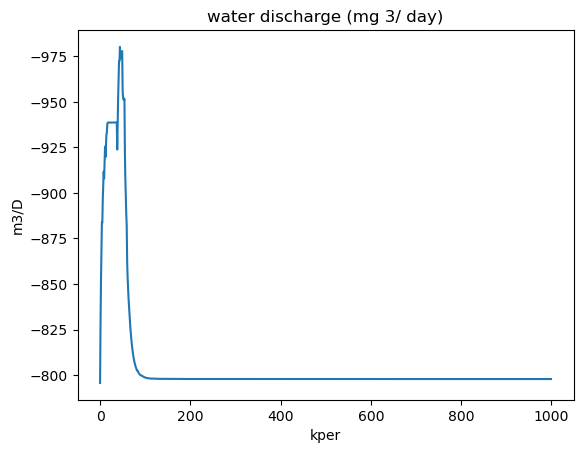

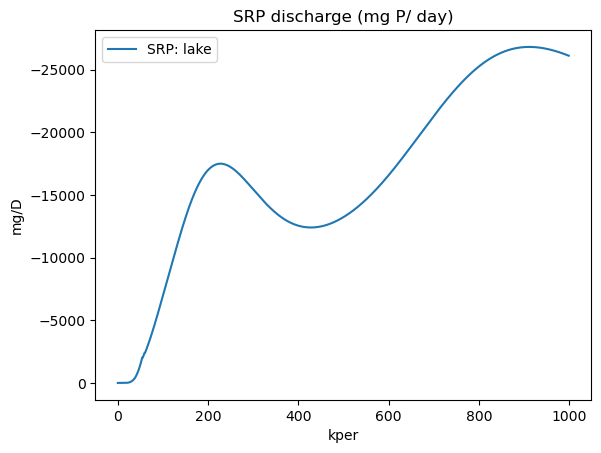

In [54]:

#ucnobj = flopy.utils.binaryfile.UcnFile(model_ws / 'MT3D001.UCN')

times = cbc.get_times()
xs = []
ys = []
ys1 =[]
ys0 =[]
ys2 = []
for n in range(len(times)):
    print(n)
    ucn= ucnobj.get_data( totim=times[n])
    ucn[ucn==1e30]=0

    ch  = cbc.get_data(text='CONSTANT HEAD', totim=times[n])[0]
    ch2 = [(np.unravel_index(i[0],(nlay,nrow,ncol)),i[1]) for i in ch]
    ch3 = [i for i in ch2 if i[0] if i[0][1]>float(2200/2/delr)] ## lake


    ys.append(0.51*-5000*2)
    ys0.append(np.sum([1*i[1] for i in ch3]))
    ys1.append(np.sum([ucn[i[0]]*i[1] for i in ch3]))
    #ys2.append(np.sum([ucn[i[0]]*i[1] for i in dr3]))
    xs.append(n)


plt.plot(xs,ys0,label='SRP: lake')
#plt.plot(xs,ys2,label = 'SRP: drain')
plt.title('water discharge (mg 3/ day)')
plt.xlabel('kper')
plt.ylabel('m3/D')
plt.gca().invert_yaxis()
plt.show()

#plt.plot(xs,ys,label='SRP: input')
plt.plot(xs,ys1,label='SRP: lake')
#plt.plot(xs,ys2,label = 'SRP: drain')
plt.title('SRP discharge (mg P/ day)')
plt.xlabel('kper')
plt.ylabel('mg/D')
plt.gca().invert_yaxis()
plt.legend()
plt.show()


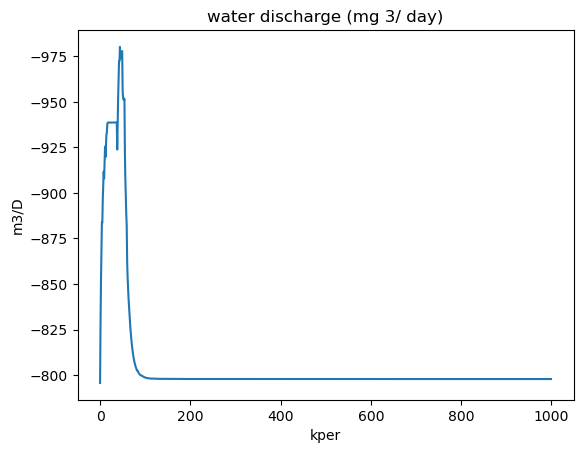

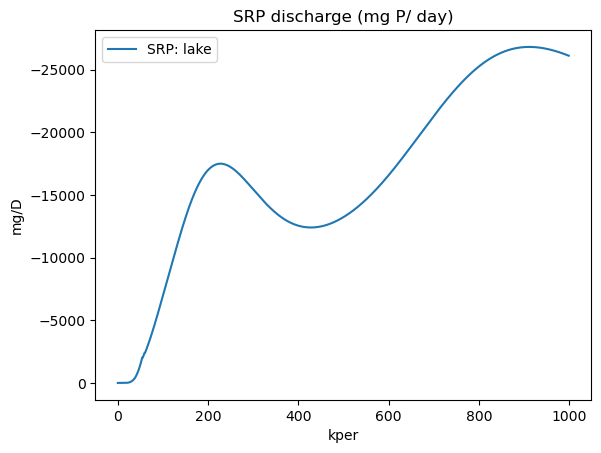

In [55]:
plt.plot(xs,ys0,label='SRP: lake')
#plt.plot(xs,ys2,label = 'SRP: drain')
plt.title('water discharge (mg 3/ day)')
plt.xlabel('kper')
plt.ylabel('m3/D')
plt.gca().invert_yaxis()
plt.show()

#plt.plot(xs,ys,label='SRP: input')
plt.plot(xs,ys1,label='SRP: lake')
#plt.plot(xs,ys2,label = 'SRP: drain')
plt.title('SRP discharge (mg P/ day)')
plt.xlabel('kper')
plt.ylabel('mg/D')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

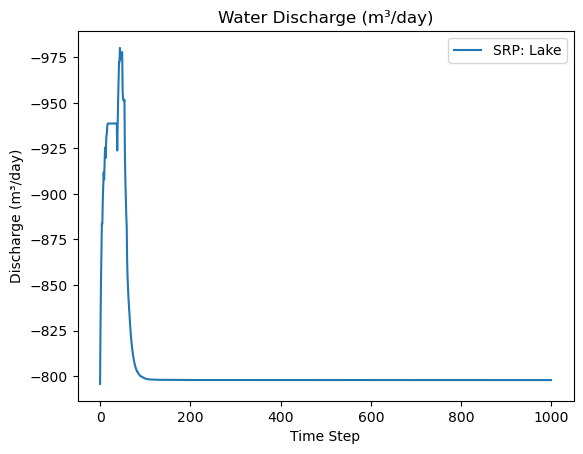

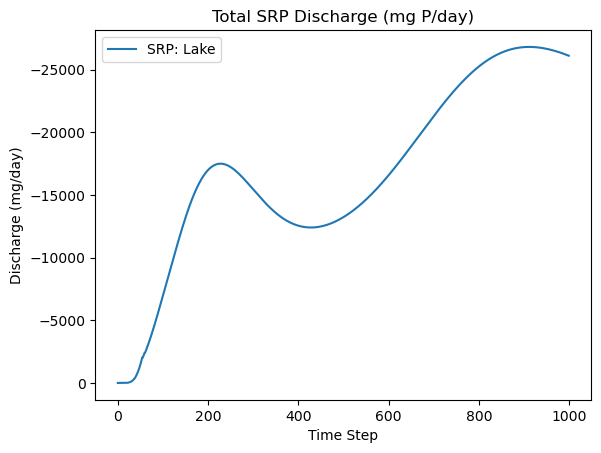

In [56]:
cellBudgetFile = cbc
concentrationFile = ucnobj

timeSteps = cellBudgetFile.get_times()
timeIndices = []
lakeDischargeM3PerDay = []
totalPhosphorusDischargeMGPerDay = []

for timeIndex in range(len(timeSteps)):
    print(timeIndex)
    concentrationData = concentrationFile.get_data(totim=timeSteps[timeIndex])
    concentrationData[concentrationData == 1e30] = 0  # Replace no-data values with 0

    constantHeadData = cellBudgetFile.get_data(text='CONSTANT HEAD', totim=timeSteps[timeIndex])[0]
    constantHeadCellIndices = [(np.unravel_index(cellIndex[0], (nlay, nrow, ncol)), cellIndex[1]) for cellIndex in constantHeadData]
    lakeCells = [cell for cell in constantHeadCellIndices if cell[0][1] > float(2200 / 2 / delr)]  # Filtering lake cells based on condition

    lakeDischargeM3PerDay.append(np.sum([cell[1] for cell in lakeCells]))
    totalPhosphorusDischargeMGPerDay.append(np.sum([concentrationData[cell[0]] * cell[1] for cell in lakeCells]))
    timeIndices.append(timeIndex)

# Plot for water discharge
plt.plot(timeIndices, lakeDischargeM3PerDay, label='SRP: Lake')
plt.title('Water Discharge (m³/day)')
plt.xlabel('Time Step')
plt.ylabel('Discharge (m³/day)')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

# Plot for Total Phosphorus Discharge
plt.plot(timeIndices, totalPhosphorusDischargeMGPerDay, label='SRP: Lake')
plt.title('Total SRP Discharge (mg P/day)')
plt.xlabel('Time Step')
plt.ylabel('Discharge (mg/day)')
plt.gca().invert_yaxis()
plt.legend()
plt.show()


In [57]:
totalPhosphorusDischargeGPerDay = np.array(totalPhosphorusDischargeMGPerDay)/1000

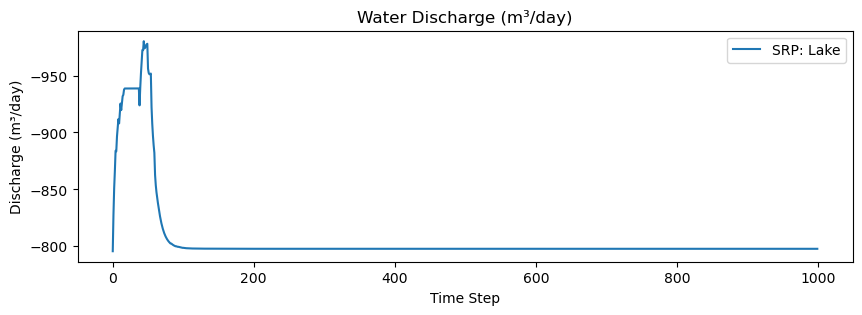

In [109]:
# Plot for water discharge
plt.plot(timeIndices, lakeDischargeM3PerDay, label='SRP: Lake')
plt.title('Water Discharge (m³/day)')
plt.xlabel('Time Step')
plt.ylabel('Discharge (m³/day)')
plt.gca().invert_yaxis()
plt.gcf().set_size_inches(10,3)
plt.legend()
plt.show()



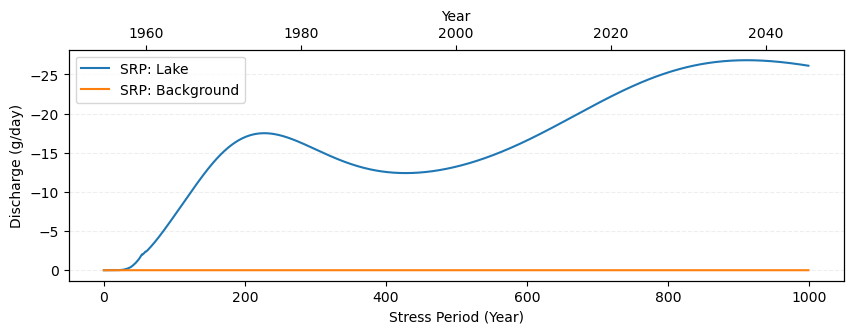

In [124]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming timeIndices, totalPhosphorusDischargeGPerDay, and lakeDischargeM3PerDay are defined

fig, ax1 = plt.subplots()
# Plot for Total Phosphorus Discharge
ax1.plot(timeIndices, totalPhosphorusDischargeGPerDay, label='SRP: Lake')
ax1.plot(timeIndices, np.array(lakeDischargeM3PerDay)*0.01/1000, label='SRP: Background')
#ax1.set_title('SRP Discharge (g P/day)')
ax1.set_xlabel('Stress Period (Year)')
ax1.set_ylabel('Discharge (g/day)')
ax1.invert_yaxis()
fig.set_size_inches(10,3)

# Add horizontal grid lines on ax1
ax1.grid(axis='y',color='#EEEEEE',linestyle='dashed')

# Create a secondary x-axis
ax2 = ax1.twiny()
# Set the limits for the new x-axis
ax2.set_xlim(1950, 2050)
# Optionally, set the label for the new x-axis
ax2.set_xlabel('Year')

# Display the legend on ax1
ax1.legend()

plt.show()


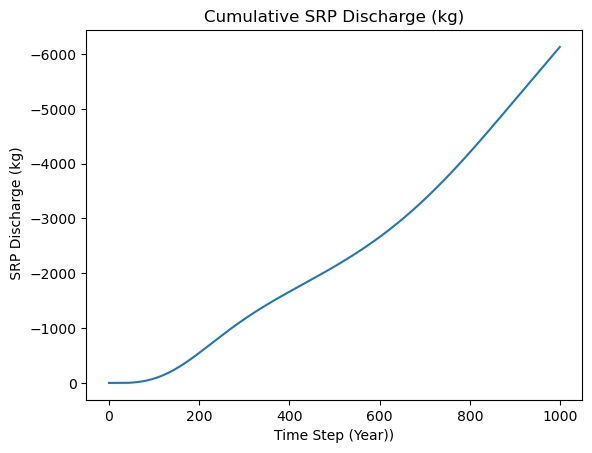

In [59]:
ys = np.cumsum(totalPhosphorusDischargeGPerDay*365/1000)
xs = range(0,len(ys))
plt.gca().invert_yaxis()
plt.title('Cumulative SRP Discharge (kg)')
plt.xlabel('Time Step (Year))')
plt.ylabel(' SRP Discharge (kg)')

plt.plot(xs,ys)

In [60]:
conc_sum_kg = []
for kper, totim in enumerate(times[0:401]):

    conc = ucnobj.get_data(totim=totim)
    conc[np.where(conc == 1e30)] = 0
    conc_sum = np.sum(conc) * delc*delr*layer_thickness/1000/1000
    conc_sum_kg.append(conc_sum)
    print(conc_sum)


print(f'All concentration maps saved to {output_folder}')

0.282041259765625
12.384959375000001
26.029782812500002
39.6004
52.25664375
65.91869375
78.56813749999999
91.0566125
103.27390625
115.8803875
128.26025
140.4624625
152.5913
164.8223625
176.965175
188.94815
201.0271125
213.08227499999998
225.11567499999998
237.127225
249.1201
261.0955
273.055825
285.0022
296.935675
308.85755
320.76847499999997
332.668975
344.5598
356.441575
368.314525
380.1798
392.0367
403.88585
415.727525
427.5625
439.39025
451.2117
483.56759999999997
503.22740000000005
521.16185
538.4580500000001
555.4362
573.1147
590.2699
605.0143499999999
619.9804499999999
635.0209
650.09925
665.2009
676.5897
688.91705
701.78165
715.0776500000001
728.68655
675.93825
669.92035
664.1613000000001
658.9429
654.68625
645.4793000000001
637.4278


KeyboardInterrupt: 

In [ ]:
ch  = cbc.get_data(text='CONSTANT HEAD', totim=times[-1])[0]
ch2 = [(np.unravel_index(i[0],(120,220,220)),i[1]) for i in ch]
ch3 = [i for i in ch2 if i[0] if i[0][1]>float(2200/2/delr)] ## lake
print(np.sum([i[1] for i in ch3]))

ch4 = [i for i in ch2 if i[0] if i[0][1]<float(2200/2/delr)] ## upland
print(np.sum([i[1] for i in ch4]))

#ch3_minus_one = [[i[0][0]-1,i[0][1],i[0][2]] for i in ch3] # water

In [ ]:
dr = cbc.get_data(text='DRAINS', totim=times[-1])[0]


dr2 = [(np.unravel_index(i[0],(120,220,220)),i[1]) for i in dr]

dr3 = [i for i in dr2 if i[0] if i[0][1]>float(2200/2/delr)] ## lakeshore
print(np.sum([i[1] for i in dr3]))


dr4 = [i for i in dr2 if i[0] if i[0][1]<float(2200/2/delr)] ## upland
print(np.sum([i[1] for i in dr4]))

#ch3_minus_one = [[i[0][0]-1,i[0][1],i[0][2]] for i in ch3] # water

## Constant Head (Lake)

In [ ]:
idx= np.where((ibound==-1))
filter = idx[1]>50
idx =(idx[0][filter],idx[1][filter],idx[2][filter])
faf[idx].sum() #m3 per day

In [ ]:
cbc = flopy.utils.CellBudgetFile(model_ws /'test.cbc', model=model)
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws / 'MT3D001.UCN')

times = cbc.get_times()
xs = []
ys = []
for n in range(len(times)):
    t = times[n]
    fff = cbc.get_data(text='FLOW FRONT FACE', totim=t)[0]
    frf = cbc.get_data(text='FLOW RIGHT FACE', totim=t)[0]
    flf = cbc.get_data(text='FLOW LOWER FACE', totim=t)[0]
    faf = flf + fff + frf
    ucn= ucnobj.get_data( totim=t)

    gw_flow = faf[idx]
    gw_flux = gw_flow.sum() #m3 per day
    ucn_flux = (gw_flow * ucn[idx]).sum()
    ys.append(ucn_flux)
    xs.append(n)
    print(ucn_flux)

plt.scatter(xs,ys)


## Drain (near shore)

In [ ]:
drn = model.drn
i0 = np.array([i[0] for i in drn.stress_period_data.data[0]])
i1 = np.array([i[1] for i in drn.stress_period_data.data[0]])
i2 = np.array([i[2] for i in drn.stress_period_data.data[0]])
drn_idx = (i0,i1,i2)


filter = drn_idx[1]>100
drn_idx =(drn_idx[0][filter],drn_idx[1][filter],drn_idx[2][filter])

faf[drn_idx].sum()

In [ ]:
cbc = flopy.utils.CellBudgetFile(model_ws /'test.cbc', model=model)
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws / 'MT3D001.UCN')

times = cbc.get_times()

xs = []
ys = []

for n in range(len(times)):
    t = times[n]
    fff = cbc.get_data(text='FLOW FRONT FACE', totim=t)[0]
    frf = cbc.get_data(text='FLOW RIGHT FACE', totim=t)[0]
    flf = cbc.get_data(text='FLOW LOWER FACE', totim=t)[0]
    faf = flf + fff + frf
    ucn= ucnobj.get_data( totim=t)

    gw_flow = faf[drn_idx]
    gw_flux = gw_flow.sum() #m3 per day
    ucn_flux = (gw_flow * ucn[drn_idx]).sum() * 365 /1000/1000
    ys.append(ucn_flux)
    xs.append(n)
    print(ucn_flux)

plt.plot(xs,ys,marker='o')
plt.gca().invert_yaxis()
#plt.ylim(0,-2000)
plt.xlabel('kper')
plt.ylabel('SRP mass flux (kg)')
plt.title('Drain (nearshore)')

## vertical boundary

In [ ]:
ibound = model.bas6.ibound.array

In [ ]:
idx= np.where((ibound !=0))
distance = 1690
distance = 1510
filter = idx[1]==int(distance/delr)
idx =(idx[0][filter],idx[1][filter],idx[2][filter])
faf[idx].sum() #m3 per day

In [ ]:
fff[idx].sum()

In [ ]:
cbc = flopy.utils.CellBudgetFile(model_ws /'example_model.cbc', model=model)
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws / 'MT3D001.UCN')

times = cbc.get_times()
xs = []
ys = []
for n in range(len(times)):
    t = times[n]
    fff = cbc.get_data(text='FLOW FRONT FACE', totim=t)[0]
    frf = cbc.get_data(text='FLOW RIGHT FACE', totim=t)[0]
    flf = cbc.get_data(text='FLOW LOWER FACE', totim=t)[0]
    faf = abs(fff) +abs(frf) +abs(flf)
    faf = np.sqrt(abs(fff)**2 +abs(frf)**2 +abs(flf)**2)
    ucn= ucnobj.get_data( totim=t)

    gw_flow = faf[idx]
    gw_flux = gw_flow.sum() #m3 per day
    ucn_flux = (gw_flow * ucn[idx]).sum() 
    ys.append(ucn_flux)
    xs.append(n)
    print(ucn_flux)

plt.plot(xs,ys,marker='o')
#plt.gca().invert_yaxis()
plt.ylim(0,8000)
plt.xlabel('kper')
plt.ylabel('SRP mass flux (mg/D)')
plt.title('x={}'.format(distance))


## aqueous and solid phase

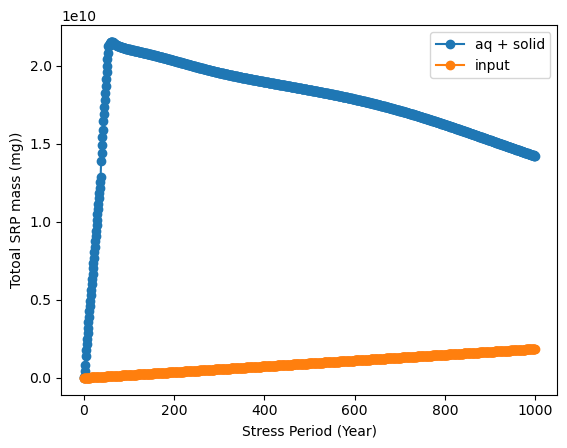

In [126]:
cmass_aq =[]
cmass_in = []
cmass_solid = []
kpers = []
ucnobj_aq = ucnobj
ucnobj_solid =  ucnobj_s
for kper in range(nper):

    # Read the concentration data from the UCN file
    if kper==0:
        source_mass = 0
    else:
        source_mass += 365*0.51*5000*2
    
    conc_array = ucnobj_aq.get_data(kstpkper=(0, kper))# (time step, stress period)
    conc_array[np.where(conc_array==1e30)] = 0
    conc_array[np.where(ibound!=1)] = 0
    c_aq = conc_array[np.where(conc_array>0.11)].sum()
    mass_aq = c_aq*delr*delc*layer_thickness* 0.25

    conc_array = ucnobj_solid.get_data(kstpkper=(0, kper))# (time step, stress period)
    conc_array[np.where(conc_array==1e30)] = 0
    conc_array[np.where(ibound!=1)] = 0
    c_solid = conc_array[np.where(conc_array>1e-7)].sum()
    mass_solid = c_solid*delr*delc*layer_thickness * 1.65E+09

    cmass_in.append(source_mass)
    cmass_aq.append(mass_aq)
    cmass_solid.append(mass_solid)
    kpers.append(kper)

ys = np.array(cmass_aq)
ys2 = np.array(cmass_in)
ys3 = np.array(cmass_solid)
ys4 = np.array(ys+ys3)
xs = kpers


SRPMassInSystem_x = xs
SRPMassInSystem_y = ys


plt.ylabel('Totoal SRP mass (mg))')
#plt.xticks(np.linspace(0,nper,5))
plt.xlabel('Stress Period (Year)')
#plt.title('mass_flux (input - output): {} '.format(cmass_in[-1] - cmass[-1]))
plt.plot(xs,ys4,marker='o',label='aq + solid')
plt.plot(xs,ys2,marker='o',label= 'input')
plt.legend()
plt.savefig(Path(model_ws)/'_output' /'mass.png')

In [161]:
SRPMassInSystem_x = xs
SRPMassInSystem_y = ys4
SRPMassInSystem_aq_y = ys
SRPMassInSystem_s_y = ys3

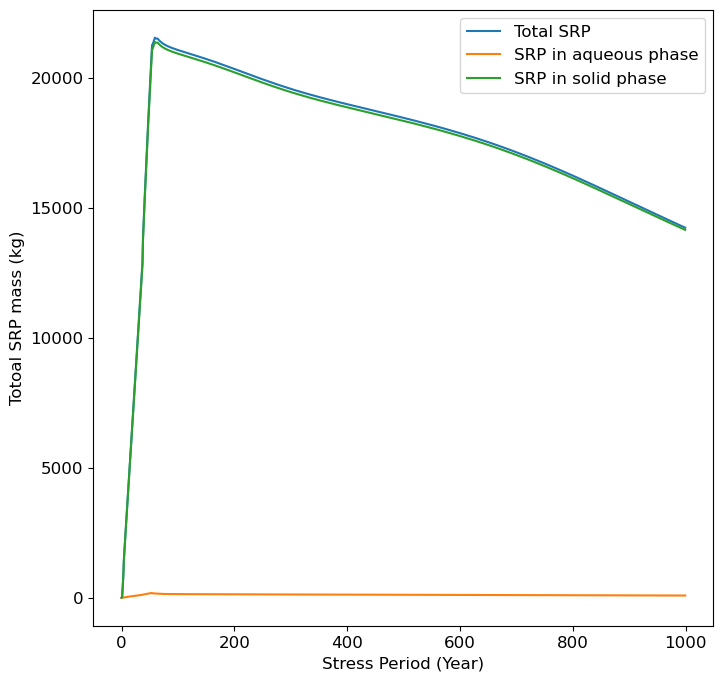

In [175]:
plt.ylabel('Totoal SRP mass (kg)')
#plt.xticks(np.linspace(0,nper,5))
plt.xlabel('Stress Period (Year)')
#plt.title('mass_flux (input - output): {} '.format(cmass_in[-1] - cmass[-1]))
plt.plot(SRPMassInSystem_x,SRPMassInSystem_y/1000000,label='Total SRP')
plt.plot(SRPMassInSystem_x,SRPMassInSystem_aq_y/1000000,label='SRP in aqueous phase')
plt.plot(SRPMassInSystem_x,SRPMassInSystem_s_y/1000000,label='SRP in solid phase')

plt.legend()
plt.gcf().set_size_inches(8,8)
plt.savefig(Path(model_ws)/'_output' /'mass.png')

In [ ]:
cmass =[]
cmass_in = []
kpers = []
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws + '/MT3D001S.UCN')
for kper in range(nper):

    # Read the concentration data from the UCN file
    if kper==0:
        source_mass = 0
    else:
        source_mass += 365*0.51*5000*2
    
    concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)
    concentration_array[np.where(concentration_array==1e30)] = 0
    concentration_array[np.where(ibound!=1)] = 0

    csum = concentration_array[np.where(concentration_array>1e-6)].sum()
    mass = csum*delr*delc*layer_thickness * 1.65E+09

    cmass_in.append(source_mass)
    cmass.append(mass)
    kpers.append(kper)

ys = np.array(cmass)/1000/1000
ys2 = np.array(cmass_in)/1000/1000
xs = kpers



plt.ylabel('Totoal SRP mass (mg))')
#plt.xticks(np.linspace(0,nper,5))
plt.xlabel('Stress Period (Year)')
plt.title('mass_flux (input - output): {} '.format(cmass_in[-1] - cmass[-1]))
plt.plot(xs,ys,marker='o',label='output')
plt.plot(xs,ys2,marker='o',label= 'input')
plt.legend()
plt.savefig(Path(model_ws)/'_output' /'mass_sorbed.png')

# MapView

In [ ]:
open_file(model_ws)

In [ ]:
## log scale

import os
import flopy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from pathlib import Path

shoreline_distance = 1600

# Assuming 'model_ws' and 'model' variables are defined and valid
ucnobj = flopy.utils.binaryfile.UcnFile(Path(model_ws) / 'MT3D001.UCN')
output_folder = Path(model_ws) / '_output' / 'log concentration_maps'

output_folder.mkdir(parents=True, exist_ok=True)

model_begin_year = 19650
times = ucnobj.get_times()
image_files = []

for kper, totim in enumerate(times[40]):

    conc = ucnobj.get_data(totim=totim)
    conc[np.where(conc == 1e30)] = 0
    conc_sum = np.sum(conc, axis=0)

    conc_sum[conc_sum<0]
    log_conc_sum = np.log10(conc_sum)
    log_conc_sum[log_conc_sum<0] = 0
    log_conc_sum = np.nan_to_num(log_conc_sum, nan=0) 

    fig, ax = plt.subplots(figsize=(10, 10))
    mapview = flopy.plot.PlotMapView(model=model)
    mapview.plot_array(log_conc_sum, vmin=0, vmax=4, ax=ax)
    
    year = totim/365 + model_begin_year +1
    year = round(year,1)

    plt.axhline(y=2200-shoreline_distance)
    plt.gca().invert_yaxis()
    plt.title(f'Concentration Map - Year {year}', pad=20)

    sm = ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=4))
    sm.set_array([])
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(sm, cax=cax, label='log10, Sum of conc in all layers')

    
    output_file = output_folder / f'concentration_map_year_{year}.png'
    plt.savefig(output_file, bbox_inches='tight',dpi=300)
    plt.close()
    image_files.append(output_file)

print(f'All concentration maps saved to {output_folder}')

In [ ]:
import os
import flopy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from pathlib import Path

# Assuming 'model_ws' and 'model' variables are defined and valid
ucnobj = flopy.utils.binaryfile.UcnFile(Path(model_ws) / 'MT3D001.UCN')
output_folder = Path(model_ws) / '_output' / 'linear_concentration_maps'

output_folder.mkdir(parents=True, exist_ok=True)

model_begin_year = 1950
times = ucnobj.get_times()
image_files = []


In [ ]:
for kper, totim in enumerate(times[400:401]):

    conc = ucnobj.get_data(totim=totim)
    conc[np.where(conc == 1e30)] = 0
    conc_sum = np.sum(conc, axis=0)
    


    fig, ax = plt.subplots(figsize=(10, 10))
    mapview = flopy.plot.PlotMapView(model=model)
    mapview.plot_array(conc_sum, vmin=0, vmax=10000, ax=ax)
    plt.axhline(y=2200-shoreline_distance)
    plt.gca().invert_yaxis()
    

    sm = ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=10000))
    sm.set_array([])
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(sm, cax=cax, label='Sum of conc in all layers')
    year = totim/365 + model_begin_year +1
    year = round(year,1)
    plt.title(f'Concentration Map - Year {year}', pad=20)
    
    output_file = output_folder / f'concentration_map_year_{year}.png'
    plt.savefig(output_file, bbox_inches='tight',dpi=300)
    plt.close()
    image_files.append(output_file)

print(f'All concentration maps saved to {output_folder}')

In [ ]:
conc_sum_sum = np.sum(conc_sum,axis=1)
xs = np.linspace(0,2200,len(conc_sum_sum))
ys = conc_sum_sum
plt.plot(xs,ys)

In [ ]:
for kper, totim in enumerate(times[0:-1:10]):

    conc = ucnobj.get_data(totim=totim)
    conc[np.where(conc == 1e30)] = 0
    conc_sum = np.sum(conc, axis=0)

    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [3, 1]})
    
    # First subplot with the concentration map
    mapview = flopy.plot.PlotMapView(model=model, ax=ax)
    mapview.plot_array(conc_sum, vmin=0, vmax=10000)
    ax.axhline(y=2200-shoreline_distance)
    ax.invert_yaxis()

    sm = ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=10000))
    sm.set_array([])
    #cax = fig.add_axes([0.85, 0.15, 0.02, 0.7])  # Adjust the colorbar position to fit the new layout
    #cbar = plt.colorbar(sm, cax=cax, label='Sum of conc in all layers')
    year = totim/365 + model_begin_year + 1
    year = round(year, 1)
    ax.set_title(f'Concentration Map - Year {year}', pad=20)

    
    # Second subplot (empty and rotated, if needed)
    conc_sum_sum = np.sum(conc_sum,axis=1)
    mass_sum_sum_g = conc_sum_sum*delr*delc*layer_thickness/1000
    ys = np.linspace(0,2200,len(mass_sum_sum_g))[::-1]
    xs = mass_sum_sum_g
    ax2.plot(xs,ys,label = 'aqueous phase')
    ax2.invert_yaxis()
    ax2.grid()
    ax2.set_title('SRP Mass (g) ', pad=20)
    ax2.legend()
    ax2.set_xlim(-100,6000)

    fig.tight_layout(pad=1.0)
    

    output_file = output_folder / f'concentration_map_year_{year}.png'
    plt.savefig(output_file, bbox_inches='tight', dpi=300)
    plt.close()
    image_files.append(output_file)

### Video

In [ ]:
import cv2

# Parameters for video creation
frame_duration = 0.1  # Duration of each image in the video
fps = int(1 / frame_duration)  # Frames per second
video_output = output_folder / 'concentration_video.mp4'

# Read the first image to determine the video resolution
frame = cv2.imread(str(image_files[0]))
height, width, layers = frame.shape

size = (width, height)

# Initialize video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can change the codec if needed
video = cv2.VideoWriter(str(video_output), fourcc, fps, size)

# Add images to video
for image_file in image_files:
    frame = cv2.imread(str(image_file))
    if frame.shape[1] != width or frame.shape[0] != height:
        raise ValueError(f"Image {image_file} has different size. All images must have the same dimensions.")
    video.write(frame)


# Release the video writer
video.release()
print(f"Video saved as {video_output}")

In [ ]:
ucnobj = flopy.utils.binaryfile.UcnFile(Path(model_ws) / 'MT3D001.UCN')
times = ucnobj.get_times()
conc = ucnobj.get_data(totim=times[-10])  # get the concentration data for the last time step
conc[np.where(conc==1e30)] = 0
conc_sum = np.sum(conc, axis=0)
mapview = flopy.plot.PlotMapView(model=model)
fig = mapview.plot_array(conc_sum,vmin=0,vmax=10000)
plt.colorbar(fig)
plt.axhline(y=2200-1700)
plt.gca().invert_yaxis()
plt.xlim(146*5-100,146*5+100)
plt.axvline(x=146*5,c='k')
#plt.ylim(900,450)
plt.gcf().set_size_inches(10,10)
plt.show()

In [ ]:
nper = model.dis.nper
ucnobj = flopy.utils.binaryfile.UcnFile(Path(model_ws) / 'MT3D001.UCN')
#for kper in range(nper)[::5]:
for kper in [3,17,59]:


    ucnobj = flopy.utils.binaryfile.UcnFile(Path(model_ws)/'MT3D001.UCN')
    times = ucnobj.get_times()
    conc = ucnobj.get_data(kstpkper=(0, kper))
    conc[np.where(conc==1e30)] = 0
    conc_sum = np.sum(conc, axis=0)
    conc_sum = np.flipud(conc_sum)
    mapview = flopy.plot.PlotMapView(model=model)
    fig = mapview.plot_array(conc_sum, cmap='coolwarm', vmin=0, vmax=800)
    #plt.show()

    plt.title('kper:{:02}'.format(kper))
    plt.xlim(650,850)
    plt.ylim(1550,1750)
    plt.colorbar(fig)
    plt.axhline(1700,c='k',linestyle = 'dashed')
    plt.axhline(1700-70,c='r')
    plt.axhline(1700-70+20,c='k')
    plt.axhline(1700-70+40,c='k')
    plt.axhline(1700-70+60,c='k')

    plt.savefig(Path(model_ws)/'_output'/'map_conc_{:02}'.format(kper))    
    
    plt.clf()

In [ ]:
open_file(model_ws)

In [ ]:
kper = 18
lay = int(nlay/2)

fig = plt.figure(figsize=(15, 5))
mapview = flopy.plot.PlotMapView(model=model, layer=lay)
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws + '/MT3D001.UCN')
concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)

ibound = model.bas6.ibound.array
mask = ((ibound== 0)|(concentration_array>=1e30))
masked_conc_data = np.ma.masked_where(mask, concentration_array)

cs = mapview.plot_array(masked_conc_data, cmap='coolwarm', vmin=0, vmax=900)
plt.colorbar(cs)

# Show the plot
plt.gcf().set_size_inches(12,12)
plt.show()

array([[[[0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
         [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
         [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
         ...,
         [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
         [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
         [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013]]],


       [[[0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
         [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
         [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
         ...,
         [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
         [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
         [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013]]],


       [[[0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
         [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.0

In [44]:
model.rch.rech.array.shape

(1000, 1, 440, 440)

# Septic Timeline

## read Septic data

In [47]:
mf = model

In [48]:
import pandas as pd

model_begin_year = 1950
def calculate_year_septic_start(df):
    # Ensure the DataFrame is sorted by 'Year'
    df = df.sort_values('Year').reset_index(drop=True)
    
    # Get the unique years and sort them
    unique_years = sorted(df['Year'].unique())
    
    # Initialize the "Year_Septic_Start" list
    year_septic_start = []
    
    # Iterate through the DataFrame rows
    for current_year in df['Year']:
        # Find the index of the current_year in the unique_years list
        current_index = unique_years.index(current_year)
        
        # Determine the previous year (if it's not the first year)
        if current_index == 0:
            #previous_year = 1950  # If it's the first unique year, use 1950
            year_septic_start.append(model_begin_year )
        else:
            previous_year = unique_years[current_index - 1]  # Get the previous unique year
        
        # Calculate the "Year_Septic_Start"
            year_septic_start.append((current_year + previous_year) // 2)
    
    # Add the "Year_Septic_Start" as a new column in the DataFrame
    df['Year_Septic_Start'] = year_septic_start
    return df

df = pd.read_csv("wasaga septics placement/septics_transformed.csv")
df = df[~df['Year End'].isna()]
df['Year End'] =df['Year End'].astype(int)
df = calculate_year_septic_start(df)
df['Year_Septic_End'] = df['Sewer_Installation_Period'].apply(lambda x: (int(x.split('-')[1]) + int(x.split('-')[0]))//2)
# Assuming necessary variables (shoreline_distance, delr, ncol, nrow, nlay, ibound) are defined
start_dis_1 = shoreline_distance - 150
end_dis_1 = shoreline_distance - 60
import numpy as np
import flopy  # Assuming flopy is already installed and imported

# Assuming nrow, ncol, delr, delc, mf are defined earlier in your code
# Define start_dist, end_dist, and exclude_range
start_dist = start_dis_1 -100  # Define start distance for exclusion (e.g., 1000 meters)
end_dist = end_dis_1    # Define end distance for exclusion (e.g., 2000 meters)
exclude_range = False  # Set to True to exclude, False to include

# Convert distances to row indices
start_row_index = int(start_dist / delr)
end_row_index = int(end_dist / delr)

# Initialize the recharge dictionary
rch_dict = {0: np.full((nrow, ncol), 0.00013, dtype=float)}  # Initial background recharge rate
# for kper in range(nper-1):
#     rch_dict = {kper: np.full((nrow, ncol), 0.00013, dtype=float)} 

# Loop through the DataFrame to update rch_dict
for index, row in df.iterrows():
    easting = row['Wasaga Easting']
    northing = row['Wasaga Northing']
    start_year = row['Year_Septic_Start']
    end_year = row['Year_Septic_End']

    # Calculate the indices
    row_index = int(northing / delr)
    col_index = int(easting / delc)

    # Check if row index is within the exclusion range and if exclusion is enabled
    if exclude_range and start_row_index <= row_index <= end_row_index:
        continue  # Skip updating for this row index

    # Calculate the range of years for each septic source
    start_key = start_year - model_begin_year + 1
    end_key = end_year - model_begin_year  + 1

    # Loop through each year for the septic source
    for year_key in range(start_key, end_key + 1):
        # Check if the key exists in the dictionary, if not, create a new array with background recharge
        if year_key not in rch_dict:
            rch_dict[year_key] = np.full((nrow, ncol), 0.00013, dtype=float)

        # Update the recharge rate at the septic location
        rch_dict[year_key][row_index, col_index] = septic_gw_flux / delr / delc
    
    # Ensure the septic is turned off after its end year
    if end_key + 1 not in rch_dict:
        rch_dict[end_key + 1] = np.full((nrow, ncol), 0.00013, dtype=float)

    # Set the recharge rate back to the background rate after the septic system's active period
    rch_dict[end_key + 1][row_index, col_index] = 0.00013

# Create the ModflowRch object
rch = flopy.modflow.ModflowRch(model=mf, rech=rch_dict)

rch_dict

c:\Users\Administrator\miniconda3\Lib\site-packages\flopy\mbase.py:658: UserWarning: Unit 19 of package RCH already in use.
  warn(
c:\Users\Administrator\miniconda3\Lib\site-packages\flopy\mbase.py:667: UserWarning: Two packages of the same type, Replacing existing 'RCH' package.
  warn(


{0: array([[0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
        [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
        [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
        ...,
        [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
        [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
        [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013]]),
 1: array([[0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
        [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
        [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
        ...,
        [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
        [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
        [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013]]),
 2: array([[0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
        [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.000

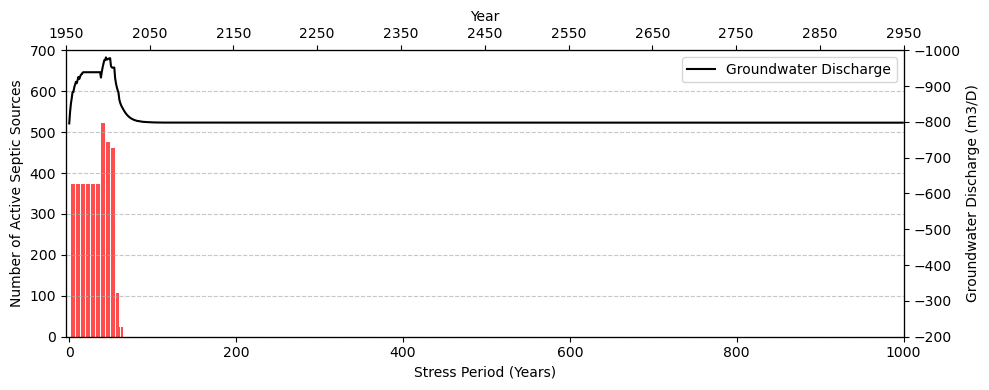

In [140]:
septic_gw_flux = 0.51
# Assuming rch_dict, delr, and delc are defined elsewhere and model_begin_year is provided

# Calculate and plot in a compact form
kpers, active_septics = zip(*sorted((year_key, np.sum(rech >= septic_gw_flux / delr / delc)) for year_key, rech in rch_dict.items()))

fig, ax1 = plt.subplots(figsize=(10, 4))
bars = ax1.bar(kpers, active_septics, color='red', alpha=0.7,label='Number of Active Septic Systems')

ax1.set(xlabel='Stress Period (Years)', ylabel='Number of Active Septic Sources', title=None)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_xlim(-4,nper)
ax1.set_ylim(0,700)

# Adding secondary x-axis on top
ax2 = ax1.twiny()  # Create a twin Axes sharing the y-axis

# Decide on the number of ticks: for example, one tick every 5 ticks from the original x-axis
kpers=range(1001)
tick_spacing = 100
selected_ticks = kpers[::tick_spacing] 
selected_labels = [str(x + model_begin_year) for x in selected_ticks]



ax2.set_xticks(selected_ticks)
ax2.set_xticklabels(selected_labels)
ax2.set_xlabel('Year')  # Set label for the secondary x-axis


ax3 = ax1.twinx()

ax3.plot(timeIndices, lakeDischargeM3PerDay,color='k',label='Groundwater Discharge')

ax3.invert_yaxis()
ax3.set_ylim(-200,-1000)
ax3.set(ylabel='Groundwater Discharge (m3/D)')
plt.legend()


#plt.xlim(0,1000)
plt.tight_layout()
plt.show()



In [131]:
selected_labels

['1950',
 '1955',
 '1960',
 '1965',
 '1970',
 '1975',
 '1980',
 '1985',
 '1990',
 '1995',
 '2000',
 '2005',
 '2010',
 '2015']

# Matplotlib 3D

In [ ]:
kper = 9
col = int(ncol)/2

# Read the concentration data from the UCN file
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws + '/MT3D001.UCN')
concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)

concentration_array[concentration_array==1e30]=0
#concentration_array[concentration_array<=0.1]=0

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


colum = int(ncol/2)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Fixing random state for reproducibility
arr = concentration_array[:,:,:colum]

coords = np.where(arr>0.11)
zs,ys,xs = coords
vs = arr[coords]
ax.scatter(xs, ys, zs, marker='o',s=1,alpha=1,cmap='coolwarm',c=vs,vmax=200)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')



ibd = model.bas6.ibound.array[:,:,0]
zs = np.array([np.where(col!=0)[0][-1]for col in ibd.T])
ys = np.arange(len(zs))
zs = list(zs) + [nlay,nlay]
ys = list(ys) + [ys[-1],0]
xs = np.repeat(colum,len(ys))

verts = [list(zip(xs, ys, zs))]
poly = Poly3DCollection(verts)
poly.set_facecolor('grey')
poly.set_edgecolor('black')
ax.add_collection3d(poly)


ibd = model.bas6.ibound.array[:,:,0]
z1 = np.array([np.where(col!=0)[0][-1]for col in ibd.T])[-1]
zs = [z1,z1,60,60]
ys = [nrow-1,nrow-1,nrow-1,nrow-1]
xs = [colum, 0,  0,colum]

verts = [list(zip(xs, ys, zs))]
poly = Poly3DCollection(verts)
poly.set_facecolor('grey')
poly.set_edgecolor('black')
ax.add_collection3d(poly)



xs = list(wt)
ys =list(np.arange(0,len(xs)))

xs = xs[::5] +xs[-1:]
ys  = ys[::5] +ys[-1:]

spline = make_interp_spline(ys, xs)
ys_smooth = np.linspace(min(ys), max(ys), 100)
xs_smooth = spline(ys_smooth)
zs_smooth = np.repeat(colum,len(xs_smooth))
ax.plot(zs_smooth,ys_smooth,xs_smooth,c='k',zorder=10)

xs = [zs_smooth[-1],zs_smooth[-1]]
ys = [ys_smooth[-1],ys_smooth[-1]]
zs = [xs_smooth[-1],52]
ax.plot(xs,ys,zs,c='k',zorder=10)

xs = [0,zs_smooth[-1]]
ys = [ys_smooth[-1],ys_smooth[-1]]
zs = [xs_smooth[-1],xs_smooth[-1]]
ax.plot(xs,ys,zs,c='k',zorder=10)


zs_smooth = np.repeat(0,len(xs_smooth))
ax.plot(zs_smooth,ys_smooth,xs_smooth,c='k',zorder=10)

xs = [zs_smooth[-1],zs_smooth[-1]]
ys = [ys_smooth[-1],ys_smooth[-1]]
zs = [xs_smooth[-1],52]
ax.plot(xs,ys,zs,c='k',zorder=10)



ax.set_xlim(0,220)
ax.set_ylim(0,220)
ax.set_zlim(0,60)
ax.view_init(elev=30, azim=30)
ax.set_box_aspect((2200,2200,30*10))
ax.invert_zaxis()


fig.set_size_inches(12,12)

plt.title('Period {}'.format(kper))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

for kper in range(0,20):



    # Read the concentration data from the UCN file
    ucnobj = flopy.utils.binaryfile.UcnFile(model_ws + '/MT3D001.UCN')
    concentration_array = ucnobj.get_data(kstpkper=(0, kper))# 
    concentration_array[concentration_array==1e30]=0

    colum = int(ncol/2)

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # Fixing random state for reproducibility
    arr = concentration_array[:,:,:colum]

    coords = np.where(arr>0)
    zs,ys,xs = coords
    vs = arr[coords]
    ax.scatter(xs, ys, zs, marker='o',s=1,alpha=1,cmap='coolwarm',c=vs,vmax=200)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')



    ibd = model.bas6.ibound.array[:,:,0]
    zs = np.array([np.where(col!=0)[0][-1]for col in ibd.T])
    ys = np.arange(len(zs))
    zs = list(zs) + [nlay,nlay]
    ys = list(ys) + [ys[-1],0]
    xs = np.repeat(colum,len(ys))

    verts = [list(zip(xs, ys, zs))]
    poly = Poly3DCollection(verts)
    poly.set_facecolor('grey')
    poly.set_edgecolor('black')
    ax.add_collection3d(poly)


    ibd = model.bas6.ibound.array[:,:,0]
    z1 = np.array([np.where(col!=0)[0][-1]for col in ibd.T])[-1]
    zs = [z1,z1,60,60]
    ys = [nrow-1,nrow-1,nrow-1,nrow-1]
    xs = [colum, 0,  0,colum]

    verts = [list(zip(xs, ys, zs))]
    poly = Poly3DCollection(verts)
    poly.set_facecolor('grey')
    poly.set_edgecolor('black')
    ax.add_collection3d(poly)



    xs = list(wt)
    ys =list(np.arange(0,len(xs)))

    xs = xs[::5] +xs[-1:]
    ys  = ys[::5] +ys[-1:]

    spline = make_interp_spline(ys, xs)
    ys_smooth = np.linspace(min(ys), max(ys), 100)
    xs_smooth = spline(ys_smooth)
    zs_smooth = np.repeat(colum,len(xs_smooth))
    ax.plot(zs_smooth,ys_smooth,xs_smooth,c='k',zorder=10)

    xs = [zs_smooth[-1],zs_smooth[-1]]
    ys = [ys_smooth[-1],ys_smooth[-1]]
    zs = [xs_smooth[-1],52]
    ax.plot(xs,ys,zs,c='k',zorder=10)

    xs = [0,zs_smooth[-1]]
    ys = [ys_smooth[-1],ys_smooth[-1]]
    zs = [xs_smooth[-1],xs_smooth[-1]]
    ax.plot(xs,ys,zs,c='k',zorder=10)

    zs_smooth = np.repeat(0,len(xs_smooth))
    ax.plot(zs_smooth,ys_smooth,xs_smooth,c='k',zorder=10)

    xs = [zs_smooth[-1],zs_smooth[-1]]
    ys = [ys_smooth[-1],ys_smooth[-1]]
    zs = [xs_smooth[-1],52]
    ax.plot(xs,ys,zs,c='k',zorder=10)

    ax.set_xlim(0,220)
    ax.set_ylim(0,220)
    ax.set_zlim(0,60)
    ax.view_init(elev=30, azim=30)
    ax.set_box_aspect((2200,2200,30*10))
    ax.invert_zaxis()

    fig.set_size_inches(12,12)
    #plt.show()
    plt.savefig(Path(model_ws) /'_output'/'{0:02d}.png'.format(kper))



from PIL import Image
import os

# Set the directory containing the PNG files
png_dir = Path(model_ws) /'_output'

# Set the output file name
gif_file = 'output.gif'

# Set the size of the resized images
size = (1000, 1000)

# Create a list of all PNG files in the directory
png_files = [f for f in os.listdir(png_dir) if f.endswith('.png')]

# Open each PNG file, resize it, and append it to a list of frames
frames = []
for png_file in png_files:
    with Image.open(os.path.join(png_dir, png_file)) as im:
        im_resized = im.resize(size)
        frames.append(im_resized)

# Save the frames as an animated GIF
frames[0].save(Path(model_ws) /'_output'/ gif_file, save_all=True, append_images=frames[1:], duration=200, loop=0)


# PyVista

In [ ]:
import numpy as np
import pyvista as pv
np.bool = np.bool_

In [ ]:

for kper in range(nper):
    # Read the concentration data from the UCN file
    ucnobj = flopy.utils.binaryfile.UcnFile(model_ws + '/MT3D001.UCN')
    concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)

    concentration_array[concentration_array==1e30]=0
    concentration_array[concentration_array<0.1]=0
    arr = concentration_array[:,:,:].T
    arr = arr[:,:,::-1]
    #arr[np.where(arr<1)]=1

    # Create the spatial reference
    grid = pv.ImageData()
    grid.dimensions = np.array(arr.shape) + 1
    grid.origin = (0,0,0)  # The bottom left corner of the data set
    grid.spacing = (delc, delr, 30/nlay)  # These are the cell sizes along each axis


    # Add the data values to the cell data
    grid.cell_data["arr"] = arr.flatten(order="F")  # Flatten the array


    pl = pv.Plotter()
    pl.add_volume(grid,cmap='rainbow')

    points = np.array([[0, 0, 0], [0,0,27],[0,2200,10],[0,2200,0],[0,0,0]])
    poly = pyvista.lines_from_points(points)
    pl.add_mesh(poly, color='lightblue', line_width=5)

    points = np.array([[0,2200,10],[0,2200,0],[2200,2200,0],[2200,2200,10],[0,2200,10]])
    poly = pyvista.lines_from_points(points)
    pl.add_mesh(poly, color='lightblue', line_width=5)


    points = np.array([[2200, 0, 0], [2200,0,27],[2200,2200,10],[2200,2200,0],[2200,0,0]])
    poly = pyvista.lines_from_points(points)
    pl.add_mesh(poly, color='lightblue', line_width=5)


    points = np.array([[0,0,27],[0,0,0],[2200,0,0],[2200,0,27],[0,0,27]])
    poly = pyvista.lines_from_points(points)
    pl.add_mesh(poly, color='lightblue', line_width=5)

    # pl.camera.position = (1100, 1100, 10)
    # pl.camera.focal_point = (1100,1200, -20)
    # pl.camera.up = (0.0, 0.0, 0.0)
    # pl.camera.zoom(1.0)

    pl.camera_position = 'yz'
    pl.camera.elevation = 45

    pl.set_scale(zscale=20)
 


    pl.show(screenshot=Path(model_ws)/'_output'/'pv_{:02}'.format(kper))

In [ ]:
# Create a figure with 2 rows and 4 columns of subplots
fig, axes = plt.subplots(3, 4)

# Load the concentration data from the UCN file
budobj = bf.UcnFile(model_ws + '/MT3D001.UCN', model=model)

# Get the times for which concentration data is available
times = budobj.get_times()

# Select 8 time indices evenly spaced throughout the simulation period
selected_indices = [int(n) for n in np.linspace(0, len(times)-1,12)]

# Loop over the selected time indices
for n in range(12):
    # Get the concentration data for the selected time
    conc = budobj.get_data(totim=times[selected_indices[n]])
    conc[conc==1.e+30] = 0
    
    # Flatten the axes array and select the nth subplot
    ax = axes.flatten()[n]
    
    # Plot the sum of the concentration data over the x-axis
    im1 = ax.imshow(np.sum(conc, axis=0), cmap='coolwarm', vmin=0, vmax=500)
    
    # Add a colorbar to the figure
    cbar_ax = fig.add_axes([0.25, 0.01, 0.5, 0.05])
    fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
    
    # Set the title of the subplot to the selected time in years
    ax.set_title('{:.1f} years'.format(times[selected_indices[n]]/365))
    
    # Add a shoreline  to the subplot
    ax.axhline(y=170*2, c='k')

# Set the size of the figure
fig.set_size_inches(20, 15)

In [ ]:
# Create a figure with 2 rows and 4 columns of subplots
fig, axes = plt.subplots(2, 4)

# Load the concentration data from the UCN file
budobj = bf.UcnFile(model_ws + '/MT3D001.UCN', model=model)

# Get the times for which concentration data is available
times = budobj.get_times()

# Select 8 time indices evenly spaced throughout the simulation period
selected_indices = [int(n) for n in np.linspace(0, len(times)-1,8)]

# Loop over the selected time indices
for n in range(8):
    # Get the concentration data for the selected time
    conc = budobj.get_data(totim=times[selected_indices[n]])
    conc[conc==1.e+30] = 0
    
    # Flatten the axes array and select the nth subplot
    ax = axes.flatten()[n]
    
    # Plot the sum of the concentration data over the x-axis
    im1 = ax.imshow(np.sum(conc, axis=0), cmap='coolwarm', vmin=0, vmax=500)
    
    # Add a colorbar to the figure
    cbar_ax = fig.add_axes([0.25, 0.01, 0.5, 0.05])
    fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
    
    # Set the title of the subplot to the selected time in years
    ax.set_title('{:.1f} years'.format(times[selected_indices[n]]/365))
    
    # Add a shoreline  to the subplot
    ax.axhline(y=140, c='k')

# Set the size of the figure
fig.set_size_inches(20, 8)

In [ ]:
xsect = flopy.plot.crosssection.PlotCrossSection(model=model, line={'Column': 100})
patches = xsect.plot_ibound()
plt.colorbar(patches)
plt.gcf().set_size_inches(10,8)

In [ ]:
xsect = flopy.plot.crosssection.PlotCrossSection(model=model, line={'Column': 100})
patches = xsect.plot_array(bas.strt.array)
plt.colorbar(patches)
plt.gcf().set_size_inches(10,4)